## Data quality check / cleaning / preparation 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.** An example is given below.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from shapely.geometry import Polygon
import geopandas as gpd
from adjustText import adjust_text

In [21]:
traffic_data = pd.read_csv('Chicago_Traffic_Tracker_-_Historical_Congestion_Estimates_by_Region_-_2018-Current.csv')

### Distribution of variables
*By Jinwen Wu*

In [22]:
# Identifying categorical and continuous variables in 'traffic_data'
categorical_cols_traffic = traffic_data.select_dtypes(include=['object', 'category']).columns.tolist()
continuous_cols_traffic = traffic_data.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Distribution for categorical variables in 'traffic_data'
cat_dist_traffic = pd.DataFrame()
for col in categorical_cols_traffic:
    cat_dist_traffic = cat_dist_traffic.append({
        'Variable': col,
        'Missing Values': traffic_data[col].isna().sum(),
        'Unique Values': traffic_data[col].nunique(),
        'Top Levels': traffic_data[col].value_counts().head(3).to_dict()
    }, ignore_index=True)

# Distribution for continuous variables in 'traffic_data'
cont_dist_traffic = traffic_data[continuous_cols_traffic].describe().transpose()

cat_dist_traffic, cont_dist_traffic

AttributeError: 'DataFrame' object has no attribute 'append'

### Data cleaning
*By Jinwen Wu and  Jessica Liu* 

In [23]:
# Dropping placeholders for 'SPEED'
traffic_data['SPEED'] = pd.to_numeric(traffic_data['SPEED'], errors='coerce')
traffic_data = traffic_data[(traffic_data['SPEED'] != -1) & (traffic_data['SPEED'] != 0)]
traffic_data['TIME'] = pd.to_datetime(traffic_data['TIME'])

# Filtering the data to include only observations within the specified time range
start_time = pd.Timestamp('2023-01-01 14:51:27')
end_time = pd.Timestamp('2023-09-08 12:51:17')

traffic_data = traffic_data[(traffic_data['TIME'] >= start_time) & (traffic_data['TIME'] <= end_time)]

/var/folders/vh/bnk8gjpn5998vq44hzdttvwc0000gn/T/ipykernel_12937/2234277687.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  traffic_data['TIME'] = pd.to_datetime(traffic_data['TIME'])


### Data preparation
*By JInwen Wu, AND Whoever Wish to work specify their work here ：）*

The following data preparation steps helped us to prepare our data for implementing various modeling/validation techniques:

1. Since we need to plot the speed onto the map of the City of Chicago, the following function of creating a polygon is used. 

2. 

In [24]:
# Data preparation in Jinwen's session 
weekdays_data = traffic_data[traffic_data['DAY_OF_WEEK'] <= 5]
weekends_data = traffic_data[traffic_data['DAY_OF_WEEK'] > 5]

# Function to create a Polygon from the boundaries
def create_polygon(row):
    return Polygon([(row['WEST'], row['NORTH']), (row['EAST'], row['NORTH']),
                    (row['EAST'], row['SOUTH']), (row['WEST'], row['SOUTH'])])

In [25]:
######-----Standardizing the dataset ----------------------#########

## Exploratory data analysis

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

### Analysis 1
*By \<Jinwen Wu>*

In [26]:
avg_speed = traffic_data.groupby('REGION')['SPEED'].mean().reset_index()
avg_speed_weekdays = weekdays_data['SPEED'].mean()
avg_speed_weekends = weekends_data['SPEED'].mean()

In [8]:
len(traffic_data['REGION'].unique())

29

In [27]:
avg_speed = avg_speed.merge(traffic_data[['REGION', 'REGION_ID', 'WEST', 'EAST', 'SOUTH', 'NORTH']], on='REGION', how='left')
avg_speed = avg_speed.drop_duplicates(subset='REGION_ID')

In [28]:
traffic_data['geometry'] = traffic_data.apply(create_polygon, axis=1)
geo_df = gpd.GeoDataFrame(traffic_data, geometry='geometry')

In [11]:
# Assuming you want to reverse the 'viridis' colormap
cmap = plt.cm.viridis
cmap_reversed = cmap.reversed()

In [ ]:
# Annotating each region with the average speed and region ID
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
geo_df.plot(column='SPEED', ax=ax, legend=True, cmap='viridis', edgecolor='black')

# Adding annotations
for idx, row in geo_df.iterrows():
    plt.annotate(f"ID: {row['REGION_ID']}\nSpeed: {row['SPEED']:.2f}", 
                 xy=(row['geometry'].centroid.x, row['geometry'].centroid.y), 
                 xytext=(3, 3), textcoords="offset points",
                 horizontalalignment='left', verticalalignment='top')

ax.set_title('Average Speed and Region IDs in Different Regions')
plt.show()

In [29]:
avg_speed['SPEED'].max(), avg_speed['SPEED'].min()

(35.8763908143288, 20.109849800029625)

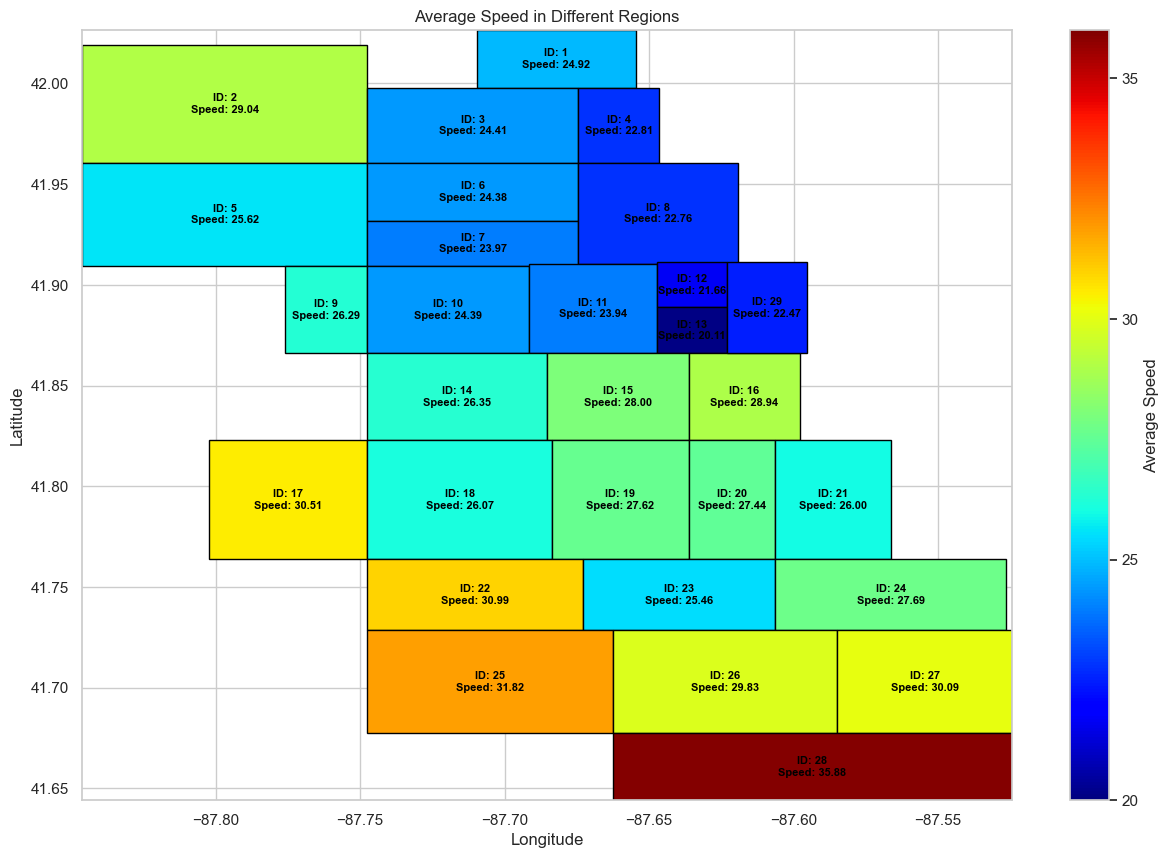

In [54]:
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(15, 10))

# Define the speed range for normalization
min_speed = 20 # Minimum speed
max_speed = 36  # Maximum speed

# Normalize the speed values for consistent coloring within the specified range
norm = mcolors.Normalize(vmin=min_speed, vmax=max_speed)

# Create a colormap with distinct colors
colormap = plt.cm.jet

# Group by region to get the boundary coordinates
region_boundaries = traffic_data.groupby('REGION_ID').agg({
    'WEST': 'mean',
    'EAST': 'mean',
    'SOUTH': 'mean',
    'NORTH': 'mean',
    'SPEED': 'mean'
}).reset_index()

# Plot each region as a rectangle with the average speed color
for _, row in region_boundaries.iterrows():
    # Define the rectangle bounds
    left = row['WEST']
    bottom = row['SOUTH']
    width = row['EAST'] - row['WEST']
    height = row['NORTH'] - row['SOUTH']
    
    # Create a rectangle patch
    rect = Rectangle((left, bottom), width, height, linewidth=1, edgecolor='black',
                     facecolor=colormap(norm(row['SPEED'])))
    
    # Add the rectangle to the Axes
    ax.add_patch(rect)

    # Annotate the rectangle with the region ID and average speed
    rx, ry = rect.get_xy()
    cx = rx + rect.get_width()/2.0
    cy = ry + rect.get_height()/2.0

    ax.annotate(f"ID: {int(row['REGION_ID'])}\nSpeed: {row['SPEED']:.2f}", (cx, cy), color='black', 
                weight='bold', fontsize=8, ha='center', va='center')

# Set the x and y axis labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Set the title
ax.set_title('Average Speed in Different Regions')

# Set axis limits
ax.set_xlim(traffic_data['WEST'].min(), traffic_data['EAST'].max())
ax.set_ylim(traffic_data['SOUTH'].min(), traffic_data['NORTH'].max())

# Create a colorbar with specified speed range
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])  # Only needed for matplotlib < 3.1
cbar = plt.colorbar(sm, ax=ax, ticks=np.arange(min_speed, max_speed+1, 5))
cbar.set_label('Average Speed')

# Show the plot
plt.grid(True)
plt.show()


In [32]:
avg_speed_by_segment_weekday = weekdays_data.groupby('REGION')['SPEED'].mean().reset_index()
region_to_id_mapping = weekdays_data[['REGION', 'REGION_ID']].drop_duplicates()
avg_speed_with_id_day = avg_speed_by_segment_weekday.merge(region_to_id_mapping, on='REGION', how='left')
avg_speed_with_id_day = avg_speed_with_id_day.sort_values(by='SPEED', ascending=True)

avg_speed_by_segment_weekend = weekends_data.groupby('REGION')['SPEED'].mean().reset_index()
region_to_id_mapping = weekends_data[['REGION', 'REGION_ID']].drop_duplicates()
avg_speed_with_id_end = avg_speed_by_segment_weekend.merge(region_to_id_mapping, on='REGION', how='left')
avg_speed_with_id_end = avg_speed_with_id_end.sort_values(by='SPEED', ascending=True)

In [33]:
# Visualization Prep
average_speed_weekdays = weekdays_data.groupby('REGION_ID')['SPEED'].mean().reset_index()
average_speed_weekends = weekends_data.groupby('REGION_ID')['SPEED'].mean().reset_index()

# Merge the weekday and weekend averages on REGION_ID
average_speed_combined = pd.merge(average_speed_weekdays, average_speed_weekends, on='REGION_ID', how='outer', suffixes=('_weekday', '_weekend'))

###  Visualization

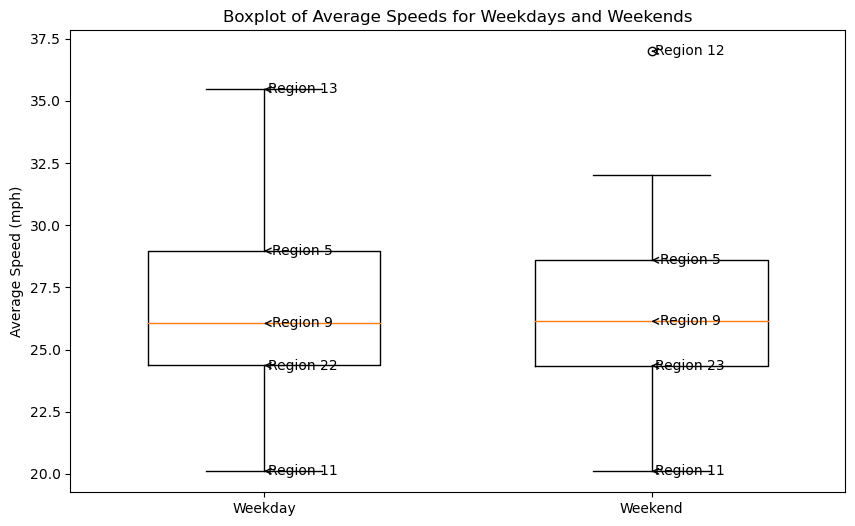

In [34]:
# Boxplot 
fig, ax = plt.subplots(figsize=(10, 6))

# Adding data for boxplots
data = [average_speed_combined['SPEED_weekday'], average_speed_combined['SPEED_weekend']]
ax.boxplot(data, positions=[1, 2], widths=0.6)

# Adding labels for identification
ax.set_xticklabels(['Weekday', 'Weekend'])
ax.set_ylabel('Average Speed (mph)')
ax.set_title('Boxplot of Average Speeds for Weekdays and Weekends')

# Annotate the statistics
for i, day_type in enumerate(['SPEED_weekday', 'SPEED_weekend'], start=1):
    stats = average_speed_combined[day_type].describe()
    y_values = [stats['min'], stats['25%'], stats['50%'], stats['75%'], stats['max']]
    region_ids = average_speed_combined.iloc[average_speed_combined[day_type].rank(method='min').astype(int) - 1]['REGION_ID']
    
    for y, region_id in zip(y_values, region_ids):
        ax.annotate(f'Region {int(region_id)}', xy=(i, y), xytext=(i+0.1, y),
                    textcoords='data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
                    ha='center', va='center')


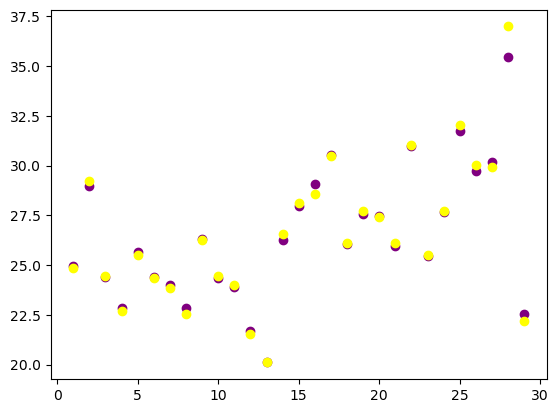

In [35]:
# Scatter Plot
plt.scatter(avg_speed_with_id_day['REGION_ID'], avg_speed_with_id_day['SPEED'], label='Weekdays', marker='o', color = 'purple')
plt.scatter(avg_speed_with_id_end['REGION_ID'], avg_speed_with_id_end['SPEED'], label='Weekends', marker='o', color = 'yellow')


### Average speeds by time

/Users/jinwens/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinwens/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinwens/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinwens/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Catego

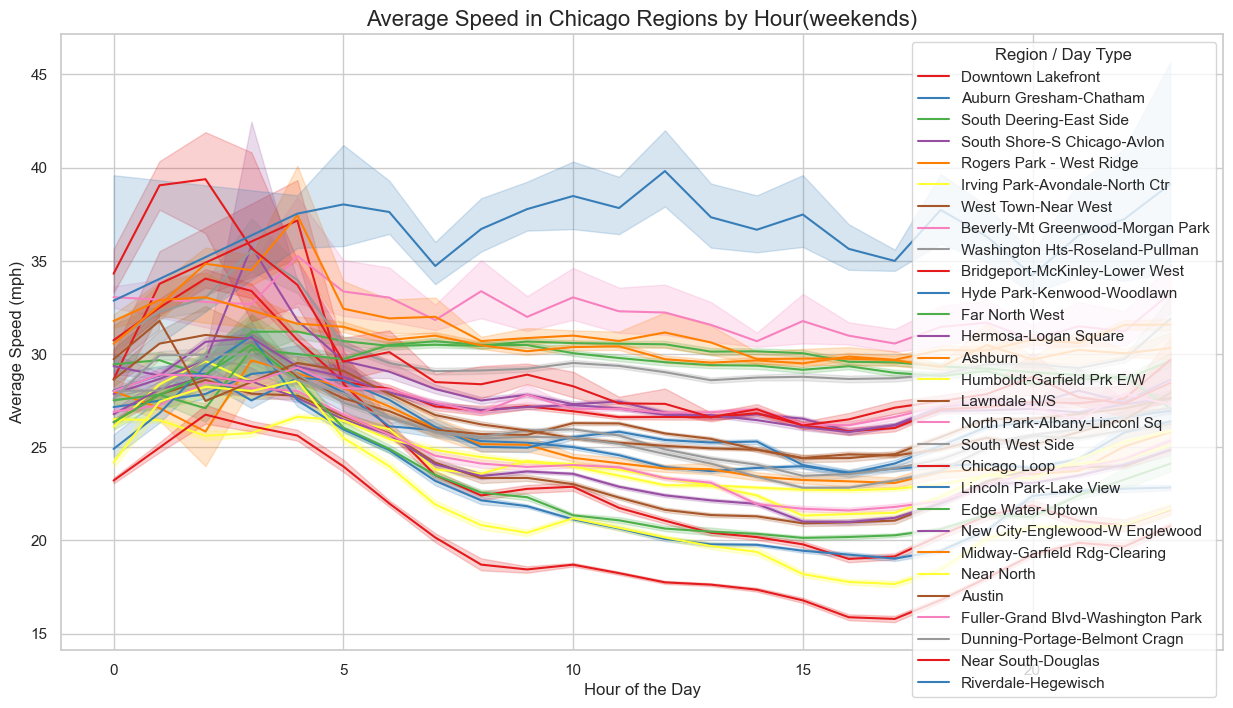

In [36]:
# Weekends
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(15, 8))
sns.lineplot(data=weekends_data, x='HOUR', y='SPEED', hue='REGION', ax=ax, palette='Set1')
ax.set_title('Average Speed in Chicago Regions by Hour(weekends)', fontsize=16)
ax.set_xlabel('Hour of the Day', fontsize=12)
ax.set_ylabel('Average Speed (mph)', fontsize=12)
ax.legend(title='Region / Day Type', loc='upper right')
plt.show()

/Users/jinwens/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinwens/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinwens/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinwens/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Catego

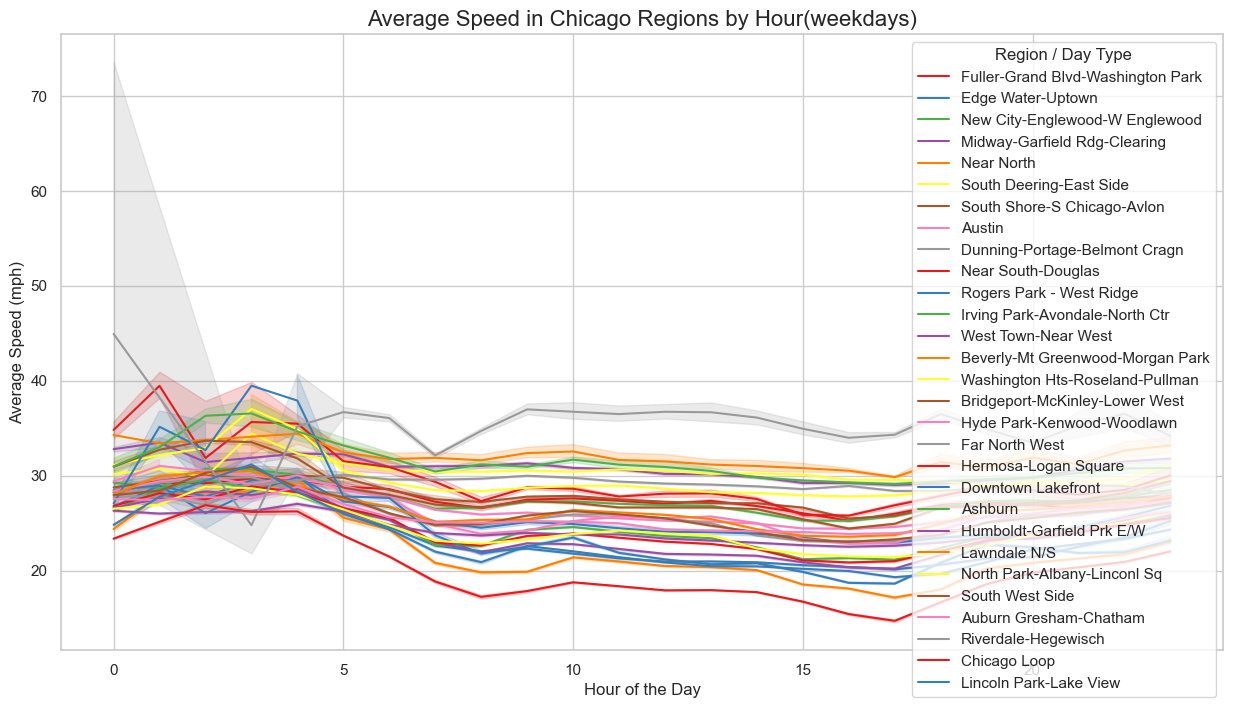

In [37]:
# Weekdays
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(15, 8))
sns.lineplot(data=weekdays_data, x='HOUR', y='SPEED', hue='REGION', ax=ax, palette='Set1')
ax.set_title('Average Speed in Chicago Regions by Hour(weekdays)', fontsize=16)
ax.set_xlabel('Hour of the Day', fontsize=12)
ax.set_ylabel('Average Speed (mph)', fontsize=12)
ax.legend(title='Region / Day Type', loc='upper right')
plt.show()

### Visualization by Regions 

In [ ]:
import geopandas as gpd
from shapely.geometry import MultiPolygon
from skimpy import clean_columns

In [40]:
regions_details = traffic_data[['REGION_ID', 'WEST', 'EAST', 'SOUTH', 'NORTH']].drop_duplicates()

In [41]:
average_speed_weekday = weekdays_data.groupby('REGION_ID')['SPEED'].mean().reset_index()
average_speed_weekend = weekdays_data.groupby('REGION_ID')['SPEED'].mean().reset_index()
weekday_data = pd.merge(regions_details, average_speed_weekday, on='REGION_ID')
weekend_data = pd.merge(regions_details, average_speed_weekend, on='REGION_ID')

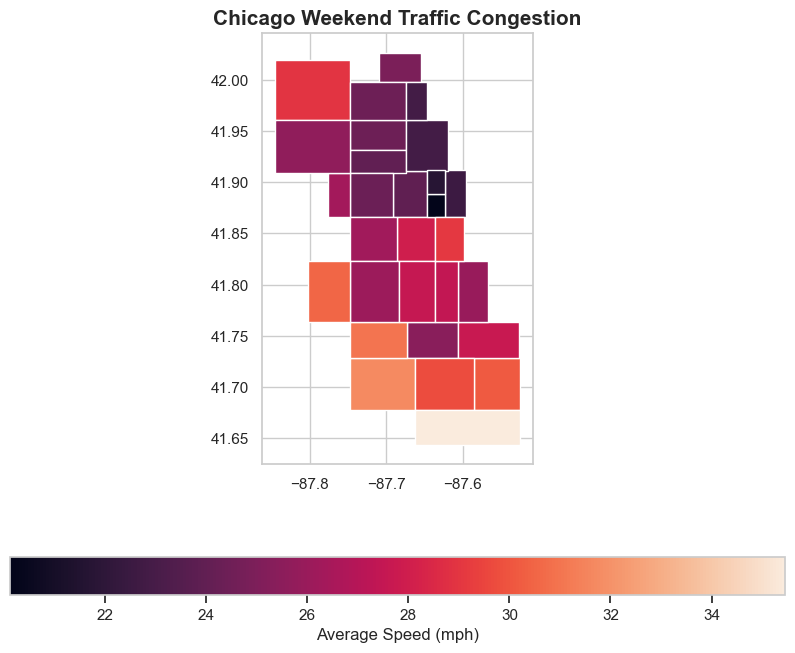

In [42]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from shapely.geometry import Polygon
import geopandas as gpd

# Create a GeoDataFrame for weekend data with a geometry column
weekend_gdf = gpd.GeoDataFrame(weekend_data, 
                               geometry=weekend_data.apply(create_polygon, axis=1),
                               crs="EPSG:4326")

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 8), dpi=100)
weekend_gdf.plot(column='SPEED', ax=ax, legend=True, 
                 legend_kwds={'label': "Average Speed (mph)", 'orientation': "horizontal"})

# Add title
ax.set_title("Chicago Weekend Traffic Congestion", fontsize=15, fontweight='bold')

# Show the plot
plt.show()


Text(0.5, 1.0, 'Chicago Weekend Traffic Congestion')

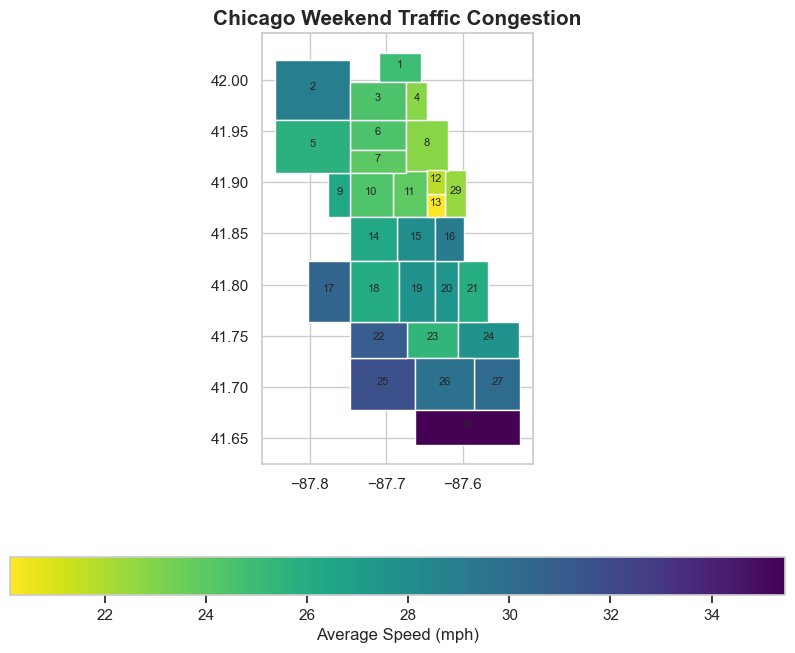

In [43]:
# Create a GeoDataFrame for weekend data with a geometry column
weekend_gdf = gpd.GeoDataFrame(weekend_data, 
                               geometry=weekend_data.apply(create_polygon, axis=1),
                               crs="EPSG:4326")


# Plotting with the reversed colormap and region names as annotations
fig, ax = plt.subplots(1, 1, figsize=(10, 8), dpi=100)
weekend_gdf.plot(column='SPEED', ax=ax, legend=True, cmap=cmap_reversed,
                 legend_kwds={'label': "Average Speed (mph)", 'orientation': "horizontal"})

# Annotate with region IDs
for idx, row in weekend_gdf.iterrows():
    plt.annotate(text=row['REGION_ID'], 
                 xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                 horizontalalignment='center', fontsize=8)
# Add title
ax.set_title("Chicago Weekend Traffic Congestion", fontsize=15, fontweight='bold')


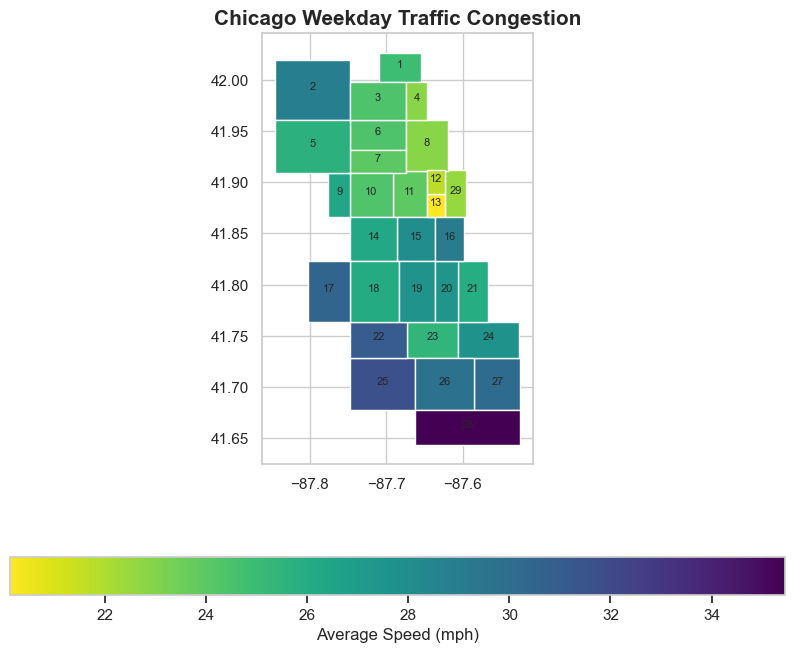

In [44]:
weekday_gdf = gpd.GeoDataFrame(weekday_data, 
                               geometry=weekday_data.apply(create_polygon, axis=1),
                               crs="EPSG:4326")

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 8), dpi=100)
weekday_gdf.plot(column='SPEED', ax=ax, legend=True, cmap=cmap_reversed, 
                 legend_kwds={'label': "Average Speed (mph)", 'orientation': "horizontal"})

for idx, row in weekday_gdf.iterrows():
    plt.annotate(text=row['REGION_ID'], 
                 xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                 horizontalalignment='center', fontsize=8)
# Add title
ax.set_title("Chicago Weekday Traffic Congestion", fontsize=15, fontweight='bold')

# Show the plot
plt.show()

In [45]:
region_names_table = traffic_data[['REGION_ID', 'REGION']].drop_duplicates().sort_values('REGION_ID').set_index('REGION_ID')
region_names_table

,REGION
REGION_ID,
1,Rogers Park - West Ridge
2,Far North West
3,North Park-Albany-Linconl Sq
4,Edge Water-Uptown
5,Dunning-Portage-Belmont Cragn
6,Irving Park-Avondale-North Ctr
7,Hermosa-Logan Square
8,Lincoln Park-Lake View
9,Austin


### Bar chart and Regions 

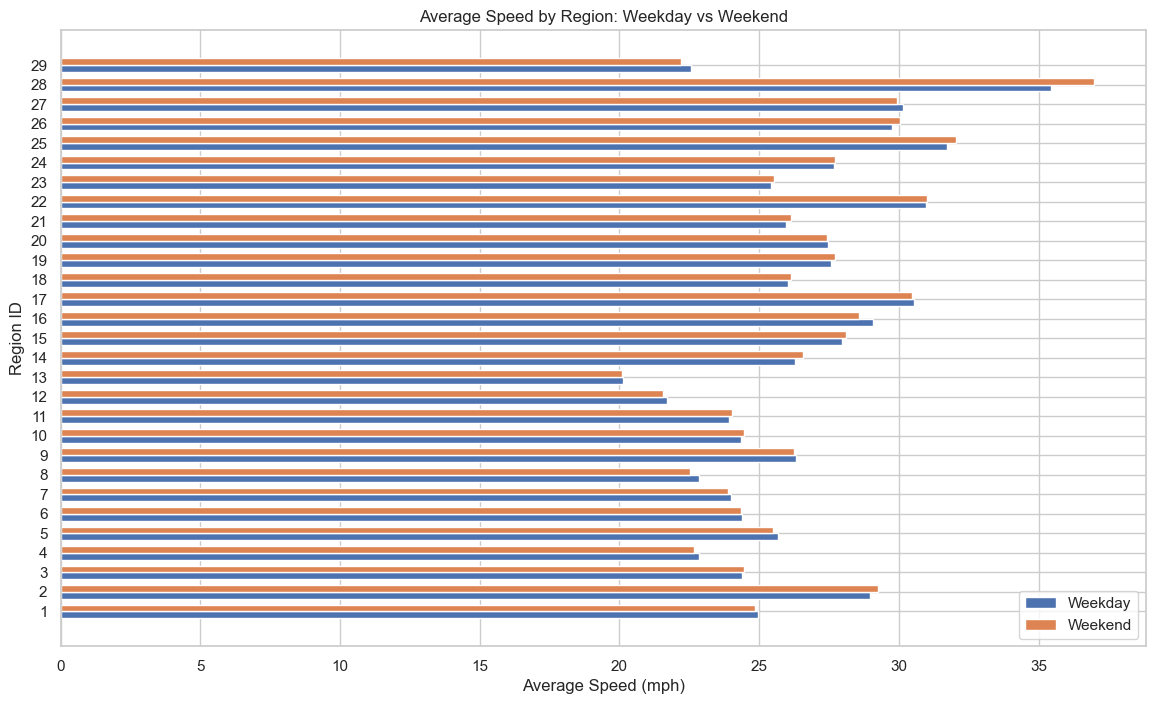

In [46]:
import matplotlib.pyplot as plt

# Assuming average_speed_combined is a DataFrame with the necessary data
# Replace NaN with 0 for regions that don't have data in either weekdays or weekends
average_speed_combined.fillna(0, inplace=True)

# Now let's plot the bar graph
fig, ax = plt.subplots(figsize=(14, 8))

# Set the positions and width for the bars
positions = list(range(len(average_speed_combined['REGION_ID'])))
width = 0.35

# Plotting both weekday and weekend speeds horizontally
bars_weekday = ax.barh([p - width/2 for p in positions], average_speed_combined['SPEED_weekday'], width, label='Weekday')
bars_weekend = ax.barh([p + width/2 for p in positions], average_speed_combined['SPEED_weekend'], width, label='Weekend')

# Adding the region names to the y-label
ax.set_yticks(positions)
ax.set_yticklabels(average_speed_combined['REGION_ID'])

# Setting the rest of the labels
ax.set_ylabel('Region ID')
ax.set_xlabel('Average Speed (mph)')
ax.set_title('Average Speed by Region: Weekday vs Weekend')
ax.legend()

# Show the plot
plt.show()


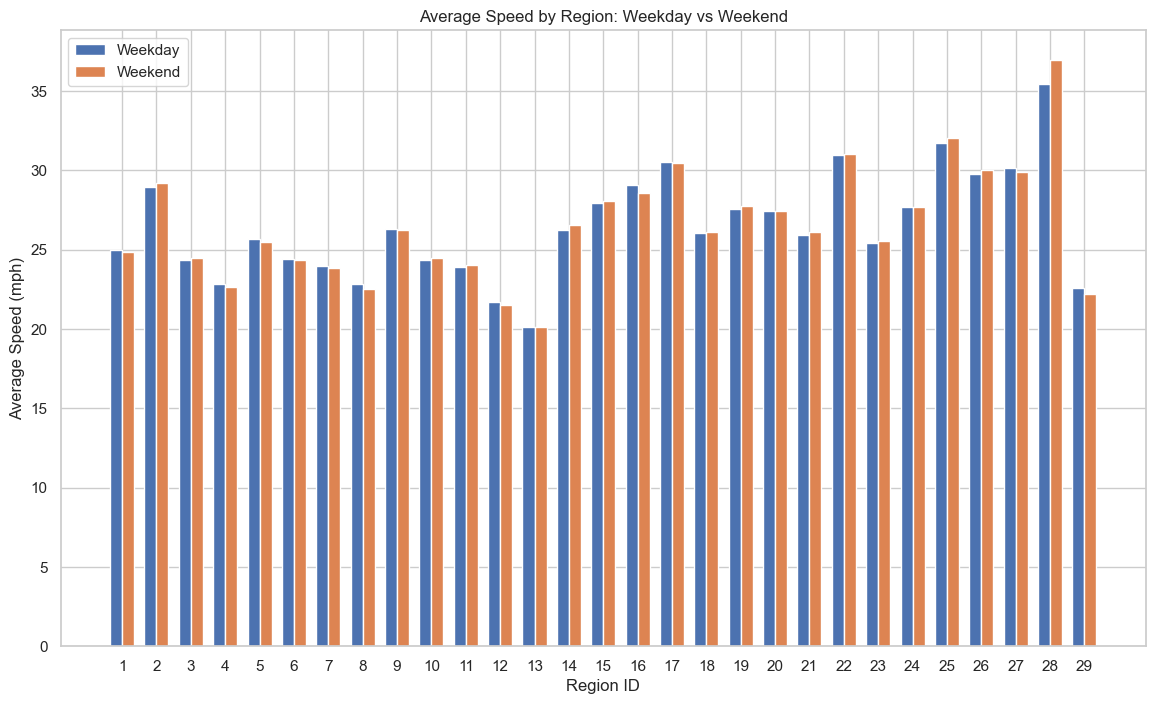

In [47]:
# Replace NaN with 0 for regions that don't have data in either weekdays or weekends
average_speed_combined.fillna(0, inplace=True)

# Now let's plot the bar graph
fig, ax = plt.subplots(figsize=(14, 8))

# Set the positions and width for the bars
positions = list(range(len(average_speed_combined['REGION_ID'])))
width = 0.35

# Plotting both weekday and weekend speeds
bars_weekday = ax.bar(positions, average_speed_combined['SPEED_weekday'], width, label='Weekday')
bars_weekend = ax.bar([p + width for p in positions], average_speed_combined['SPEED_weekend'], width, label='Weekend')

# Adding the region names to the x-label
ax.set_xticks([p + width/2 for p in positions])
ax.set_xticklabels(average_speed_combined['REGION_ID'])

# Setting the rest of the labels
ax.set_xlabel('Region ID')
ax.set_ylabel('Average Speed (mph)')
ax.set_title('Average Speed by Region: Weekday vs Weekend')
ax.legend()

# Show the plot
plt.show()

In [48]:
combined_gdf = gpd.GeoDataFrame(average_speed_combined, 
                               geometry=weekday_data.apply(create_polygon, axis=1),
                               crs="EPSG:4326")

In [49]:
combined_gdf['weekends_faster'] = combined_gdf['SPEED_weekday'] > combined_gdf['SPEED_weekend']
combined_gdf['weekdays_faster'] = combined_gdf['SPEED_weekday'] < combined_gdf['SPEED_weekend']

In [50]:
faster_weekends_gdf = combined_gdf[combined_gdf['weekends_faster']]
faster_weekdays_gdf = combined_gdf[combined_gdf['weekdays_faster']]

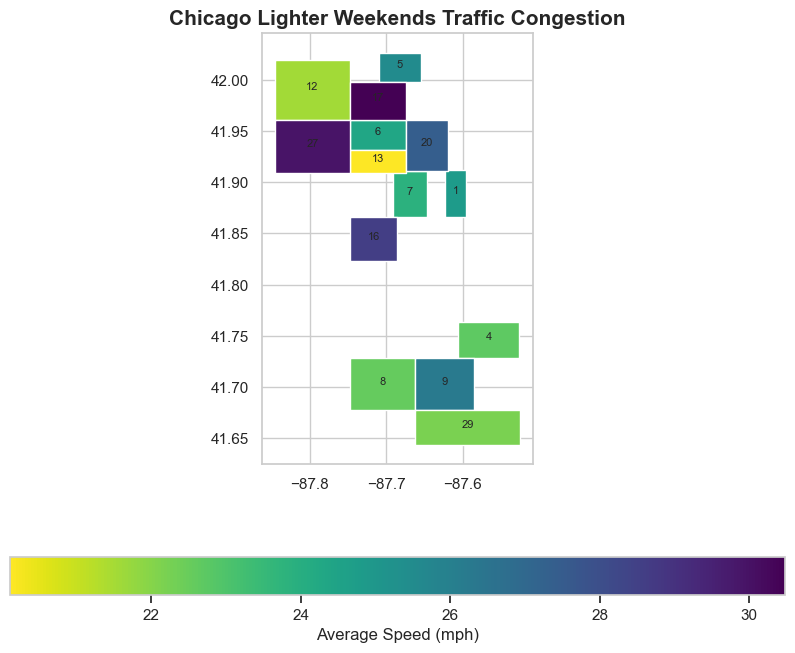

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8), dpi=100)
faster_weekends_gdf.plot(column='SPEED_weekend', ax=ax, legend=True, cmap=cmap_reversed, 
                 legend_kwds={'label': "Average Speed (mph)", 'orientation': "horizontal"})

for idx, row in faster_weekends_gdf.iterrows():
    plt.annotate(text=row['REGION_ID'], 
                 xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                 horizontalalignment='center', fontsize=8)
# Add title
ax.set_title("Chicago Lighter Weekends Traffic Congestion", fontsize=15, fontweight='bold')

# Show the plot
plt.show()

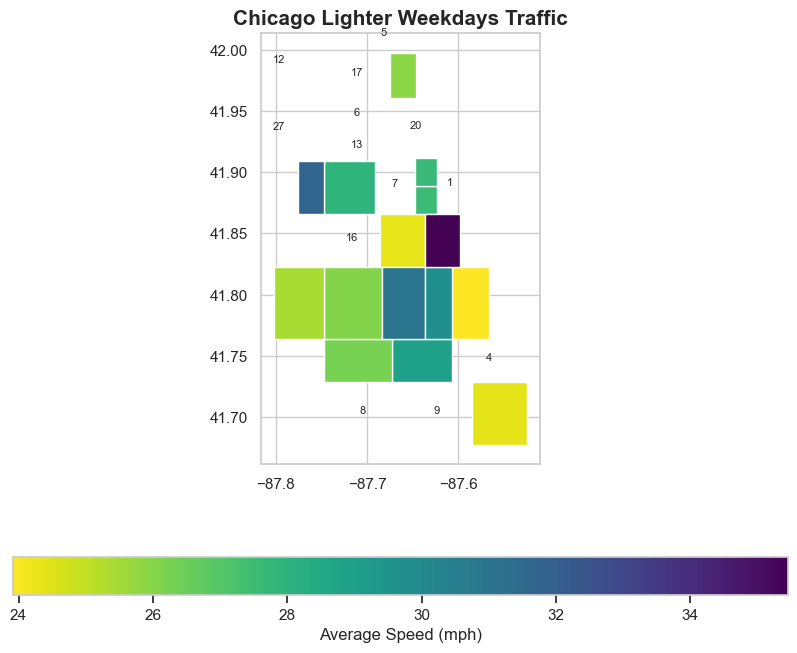

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8), dpi=100)
faster_weekdays_gdf.plot(column='SPEED_weekday', ax=ax, legend=True, cmap=cmap_reversed, 
                 legend_kwds={'label': "Average Speed (mph)", 'orientation': "horizontal"})

for idx, row in faster_weekends_gdf.iterrows():
    plt.annotate(text=row['REGION_ID'], 
                 xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                 horizontalalignment='center', fontsize=8)
# Add title
ax.set_title("Chicago Lighter Weekdays Traffic", fontsize=15, fontweight='bold')

# Show the plot
plt.show()

### Analysis 2
*By \<Name of person doing the analysis>*

### Analysis 3
*By \<Name of person doing the analysis>*

### Analysis 4
*By \<Name of person doing the analysis>*

## Other sections

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

Put each model in a section of its name and mention the name of the team-member tuning the model. Below is an example:

## Conclusions and Recommendations to stakeholder(s)

You may or may not have code to put in this section. Delete this section if it is irrelevant.